# Propagación de incertidumbres
Ademas de la ecuación para propagar errores de una función general, principalmente se utilizaron las siguientes fórmulas para propagar errores:
-  Sumas y/o restas de parámetros:
$$
F \left(\mathbf{x}, \mathbf{y}\right) = \sum_{i=1}^n x_i - \sum_{i=1}^m y_i \implies \Delta F = \sqrt{\sum_{i=1}^n \left(\Delta x_i\right)^2 + \sum_{i=1}^m \left(\Delta y_i\right)^2}
$$

-  Productos y/o divisiones de parámetros:
$$
G \left(\mathbf{x}, \mathbf{y}\right) = \frac{\prod_{i=1}^n x_i}{\prod_{i=1}^m y_i} \implies \Delta G = \vert G \vert \sqrt{\sum_{i=1}^n \left(\frac{\Delta x_i}{x_i}\right)^2 + \sum_{i=1}^m \left(\frac{\Delta y_i}{y_i}\right)^2} \Longleftrightarrow \delta G = \sqrt{\sum_{i=1}^n \left(\delta x_i\right)^2 + \sum_{i=1}^m \left(\delta y_i\right)^2}
$$

Siendo $\delta G$ la incertidumbre relativa de $G$.

In [1]:
#@title Librerías usadas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t

In [2]:
#@title Función de regresión lineal por método de mínimos cuadrados
def OLS_regr(X, Y, **kwargs):
  N = len(X)
  SX = np.sum(X)
  SY = np.sum(Y)
  SXX = np.sum(X*X)
  SYY = np.sum(Y*Y)
  SXY = np.sum(X*Y)

  P1 = SX*SY - N*SXY
  P2 = SX*SXY - SY*SXX
  Q = SX**2 - N*SXX

  a = P1/ Q
  b = P2 / Q

  linear_X = a*X + b
  ji2 = np.sum(np.power(Y - linear_X, 2))

  SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
  SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
  r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

  if N < 30:
    SE_a *= t.ppf(.975, N - 1)
    SE_b *= t.ppf(.975, N - 1)

  for key, value in kwargs.items():
    if key == 'Delta_X':
      Delta_X = value
      continue
    elif key == 'Delta_Y':
      Delta_Y = value
      continue
  try:
    Delta_X
    Delta_Y
  except NameError:
    return a, b, SE_a, SE_b, r
  else:
    Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
    Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
    Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
    Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

    Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
    Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
    Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

    Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
    Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

    return a, b, SE_a, SE_b, Delta_a, Delta_b, r



In [28]:
#@title Extracción de los datos experimentales
url = 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Emisi%C3%B3n%20termoi%C3%B3nica/datos_grupo_4.csv'
df = pd.read_csv(url, sep=';')

# Voltajes y corrientes del filamento
datos_filamento = df.head(1).copy()
datos_filamento.dropna(axis=1, how='all', inplace=True)
datos_filamento = datos_filamento.iloc[0].tolist()
I_h, V_h = np.array(datos_filamento[::2], dtype=np.float64), np.array(datos_filamento[1::2], dtype=np.float64)

# Voltajes de aceleración y corriente termoiónica
df.drop(df.index[[0, 1]], inplace=True)
df.dropna(axis=1, how='all', inplace=True)
datos = np.transpose(df.to_numpy(dtype=np.float64))
V_a = datos[::2]  # [V]
I_a = datos[1::2] / 1000  # [A]

In [4]:
#@title Datos
# Constantes físicas
SIGMA_SB = 5.670374419e-8  # [W m^-2 K^-4]
EPSILON_0 = 8.8541878188e-12  # [F m^-1]
DELTA_EPSILON_0 = 1.4e-21  # [F m^-1]
K_BOLTZMANN = 1.380649e-23  # [J K^-1]

# Constantes experimentales
L = .25 * 2.54 / 100  # [m]
DELTA_L = .001 * 2.54 / 100  # [m]
L_EFECTIVA = .7 * L  # [m]
DELTA_L_EFECTIVA = .7 * DELTA_L  # [m]
D = 0.005 * 2.54 / 100  # [m]
DELTA_D = 0.001 * 2.54 / 100  # [m]
R = D / 2  # [m]
DELTA_R = DELTA_D / 2  # [m]
AREA_FILAMENTO = np.pi * D * L  # [m²]
DELTA_AREA_FILAMENTO = AREA_FILAMENTO * np.sqrt((DELTA_D / D)**2 + (DELTA_L_EFECTIVA / L_EFECTIVA))
RADIO_ANODO = 0.62 * 2.54 / 200  # [m]
DELTA_RADIO_ANODO = 0.001 * 2.54 / 200 # [m]
BETA2 = 1.072
R_W_293K = 0.135
Delta_R_W_293K = 0.001

# Incertidumbres del voltaje y corriente en el filamento
Incertidumbre_amperimetro = 0.01
Incertidumbre_voltimetro = 0.01
Delta_V_h = np.array([Incertidumbre_voltimetro] * len(V_h))
Delta_I_h = np.array([Incertidumbre_amperimetro] * len(I_h))

In [5]:
#@title Tabla de corriente y voltaje del filamento después de 30 segundos
df = pd.DataFrame({
  'I_h [A]': I_h,
  'ΔI_h [A]': Delta_I_h,
  'V_h [V]': V_h,
  'ΔV_h [V]': Delta_V_h,
})

df.index += 1
display(df)

,I_h [A],ΔI_h [A],V_h [V],ΔV_h [V]
1,1.80,0.01,2.62,0.01
2,1.85,0.01,2.76,0.01
3,1.90,0.01,2.89,0.01
4,1.95,0.01,3.02,0.01
5,2.00,0.01,3.16,0.01
6,2.05,0.01,3.30,0.01
7,2.10,0.01,3.46,0.01
8,2.16,0.01,3.62,0.01
9,2.21,0.01,3.80,0.01


In [6]:
#@title Cálculo de $R_\text{soporte}$
R_measured = 11.6 / 54.3  # [mV / mA], Medida con corrientes bajas para evitar que se caliente mucho el filamento
Delta_R_measured = R_measured * np.sqrt((0.1 / 11.6)**2 + (0.1 / 54.3)**2)
R_soporte = R_measured - R_W_293K
Delta_R_soporte = np.sqrt(Delta_R_measured**2 + Delta_R_W_293K**2)

print(f'Valor de la resistencia del filamento a temperatura ambiente = ({R_W_293K:.3f} ± {Delta_R_W_293K:.3f}) Ω')
print(f'Valor de la resistencia del soporte = ({R_soporte:.3f} ± {Delta_R_soporte:.3f}) Ω')

Valor de la resistencia del filamento a temperatura ambiente = (0.135 ± 0.001) Ω
Valor de la resistencia del soporte = (0.079 ± 0.002) Ω


In [7]:
#@title Determinación de las resistencias $R_{\text{total}}$ y $R_\mathrm{W}$ y la temperatura
R_measured = V_h / I_h
Delta_R_measured = R_measured * np.sqrt(np.power(Delta_I_h / I_h, 2) + np.power(Delta_V_h / V_h, 2))
R_W = R_measured - R_soporte
Delta_R_W = np.sqrt(np.power(Delta_R_measured, 2) + Delta_R_soporte**2)

x = R_W / R_W_293K
Delta_x = x*np.sqrt(np.power(Delta_R_W / R_W, 2) + (Delta_R_W_293K / R_W_293K)**2)
T_r = 112 + 202 * x - 1.81 * np.power(x, 2)
Delta_T_r = np.abs(202 - 3.62 * x) * Delta_x

In [8]:
#@title Tabla valores $R_{\text{total}}$, $R_\mathrm{W}$ y $T_r$
df = pd.DataFrame({
  'R_total [Ω]': R_measured,
  'ΔR_total [Ω]': Delta_R_measured,
  'R^W [Ω]': R_W,
  'ΔR^W [Ω]': Delta_R_W,
  'T_r [K]': T_r,
  'ΔT_r [K]': Delta_T_r,
})

df.index += 1
display(df)

,R_total [Ω],ΔR_total [Ω],R^W [Ω],ΔR^W [Ω],T_r [K],ΔT_r [K]
1,1.455556,0.009811,1.376928,0.010040,1983.999024,17.500555
2,1.491892,0.009708,1.413264,0.009940,2028.299954,17.547778
3,1.521053,0.009581,1.442425,0.009815,2063.662777,17.552260
4,1.548718,0.009454,1.470090,0.009691,2097.055989,17.555666
5,1.580000,0.009349,1.501372,0.009589,2134.631618,17.593412
6,1.609756,0.009244,1.531128,0.009487,2170.193909,17.627888
7,1.647619,0.009178,1.568991,0.009422,2215.190643,17.724414
8,1.675926,0.009035,1.597298,0.009283,2248.644817,17.731455
9,1.719457,0.009000,1.640829,0.009250,2299.780984,17.875884


# Relación de potencia eléctrica y potencia emisiva de Stefan-Boltzmann

Por conservación de la energía, en la malla de la fuente de voltaje del filamento y el filamento, suponiendo que el voltímetro y amperímetro son ideales, debe haber una pérdida de energía debido a los cables de la forma:

$$
E_\text{fuente} (t) = E_\text{filamento} (t) + E_\text{disipada} (t).
$$

En este caso, dado que la energía medida no es la de la fuente sino la energía entregada al filamento, se puede considerar este sistema como uno equivalente sin pérdidas de energía y con la energía total siendo $E_\text{filamento} (t) = V_h I_h t$.

De forma similar en el filamento se puede considerar que esta energía suministrada se transforma en energía térmica. En nuestro caso, esta energía térmica se disipa principalmente por emisión termoiónica y en parte menor por otros efectos (e.g. radiación electromagnética). Matemáticamente se puede expresar como:

$$
E_\text{suministrada} (t) = E_\text{termica} (t) = E_\text{emision} (t) + E_\text{disipada} (t).
$$

Como se dijo anteriormente, la energía suministrada sobre el filamento es la misma energía sobre el filamento, que por efecto Joule $E_\text{suministrada} (t) = I_h^2 R^\mathrm{W} t$.

Reemplazando en la expresión para la energía sobre el filamento:

$$
I_h^2 R^\mathrm{W} t = E_\text{emision} (t) + E_\text{disipada} (t).
$$

Suponiendo que la proporción de las energías en las que se transforma $E_\text{termica} (t)$ es independiente del tiempo (no hay periodos de tiempo donde la mayor o menor parte de la energía transformada es de efectos disipativos), entonces

$$
I_h^2 R^\mathrm{W} t = E_\text{emision} \cdot t + \Delta E \cdot t,
$$

y derivando respecto al tiempo

$$
I_h^2 R^\mathrm{W} = \frac{\mathrm{d}}{\mathrm{d} t} [E_\text{emision}] + \frac{\mathrm{d} \Delta E}{\mathrm{d} t} = P_\text{emision} + C,
$$

donde $k$ representa las pérdidas de energía suministrada en energías no termoiónicas. Reemplazando esta potencia de emisión con la ley de Stefan-Boltzmann para un cuerpo gris y tomando $C = 0$ finalmente se tiene:

$$
\boxed{I_h^2 R^\mathrm{W} = \epsilon_T \sigma A T^4.}
$$

Despejando $T$:

$$
T = \left(\frac{1}{\epsilon_T \sigma A}\right)^{1/4} \left(I_h^2 R^\mathrm{W}\right)^{1/4}
$$

Suponiendo que nuestro sistema es ideal, entonces, para comprobar la relación anterior se debe hace una regresión por MMC de la forma

$$
T = B \left(I_h^2 R^\mathrm{W}\right)^a
$$

con $X = \ln T$ y $Y = \ln \left(I^2_h R^\mathrm{W}\right)$, donde la potencia esperada $a = 0.25$.

> En este caso la emisividad se puede calcular como
> $$
B = e^{b/a} = \left(\frac{1}{\epsilon_T \sigma A}\right)^{1/4} \implies \epsilon_T = \frac{e^{- 4 b/a}}{\sigma A}
$$

Habiendo confirmado la relación potencial, esta vez se puede realizar una regresión lineal sobre el sistema con pérdidas de la expresión:

$$
T^4 = m I^2_h R^\mathrm{W} + C,
$$

donde $X = T^4$ y $Y = I^2_h R^\mathrm{W}$; de esta forma la emisividad total del filamento se puede calcular como

$$
\boxed{\epsilon_T = \frac{1}{m \sigma A}.}
$$

In [9]:
#@title Regresión potencial por MMC para la ley de Stefan-Boltzmann
P_electrica = np.power(I_h, 2) * R_W
Delta_P_electrica = np.sqrt(np.power(2 * I_h * R_W * Delta_I_h, 2) + np.power(I_h, 4) * np.power(Delta_R_W, 2))

a, b, delta_a, delta_b, r_SB = OLS_regr(np.log(P_electrica), np.log(T_r))

print(f'Potencia de la regresión = {1 / a:.1f} ± {delta_a / a**2:.1f}')
print(f'R² = {r_SB*r_SB:.4f}')

print(f'Emisividad calculada (considerando pérdidas nulas) = {np.exp(- 4 * b / a) / (SIGMA_SB * AREA_FILAMENTO):.3e}')  # del área [cm²] -> [m²]

x_values = np.linspace(4, 8.6, num=50)
y_lims = np.array([1900, 2400])

Potencia de la regresión = 4.0 ± 0.1
R² = 0.9991
Emisividad calculada (considerando pérdidas nulas) = 1.375e-38


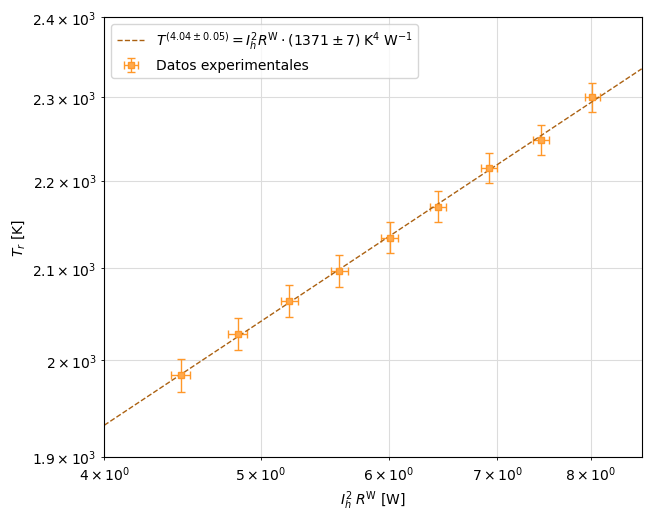

In [10]:
#@title Gráfica potencia eléctrica contra temperatura (escala logarítmica)
fig, ax = plt.subplots(figsize=(6.4, 5.1), layout='constrained')
ax.errorbar(
  P_electrica,
  T_r,
  xerr=Delta_P_electrica,
  yerr=Delta_T_r,
  mfc='#ffa94d',
  mec='#ff9829',
  ecolor='#ff9829',
  elinewidth=1,
  label='Datos experimentales',
  zorder=2,
  capsize=3,
  ms=4.5,
  fmt='s',
)
ax.plot(
  x_values,
  np.exp(b)*np.power(x_values, a),
  ls='--',
  c='#ab6111',
  lw=1,
  label='$T^{(4.04 \pm 0.05)} = I_h^2 R^\mathrm{W} \cdot (1371 \pm 7) \; \mathrm{K}^4 \; \mathrm{W}^{-1}$',
  zorder=2,
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([x_values[0], x_values[-1]])
ax.set_ylim(y_lims)
ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_on()
ax.grid(True, which='both', color='gainsboro')
ax.set_xlabel('$I_h^2 \; R^\mathrm{W}$ [W]')
ax.set_ylabel('$T_r$ [K]')
ax.legend(loc='upper left')

plt.savefig("grafica_Stefan_Boltzmann.pdf", format="pdf")

In [11]:
#@title Regresión lineal para determinar la emisividad total del filamento
m, k, delta_m, delta_k, r = OLS_regr(P_electrica, np.power(T_r , 4))

emisividad_W = .1 / (m * SIGMA_SB * AREA_FILAMENTO)
Delta_emisividad_W = emisividad_W * np.sqrt((delta_m / m)**2 + (DELTA_AREA_FILAMENTO / AREA_FILAMENTO)**2)
print(f'Emisividad del filamento = {emisividad_W:.2f} ± {Delta_emisividad_W:.2f}')
print(f'Factor de pérdida de energía C = ({k:.0e} ± {delta_k:.0e})')
print(f'R² = {r*r:.4f}')

Emisividad del filamento = 0.20 ± 0.04
Factor de pérdida de energía C = (1e+11 ± 6e+11)
R² = 0.9988


In [12]:
colores = ['#0000FF', '#004CFF', '#0099FF', '#00E5FF', '#00FFCC', '#00FF7B', '#00FF2F', '#1EFF00', '#6AFF00']
colores_err = ['#0000B2', '#0036B2', '#006CB2', '#00A1B2', '#00B28E', '#00B259', '#00B21F', '#16B200']

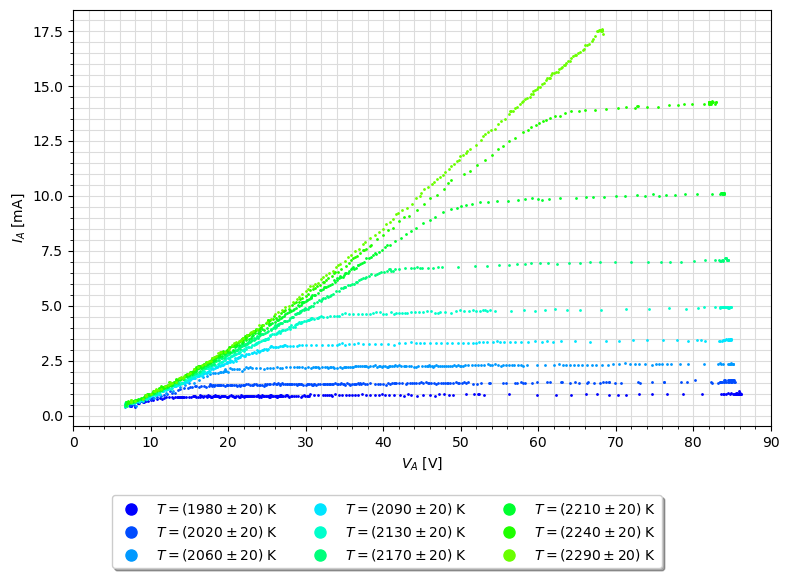

In [29]:
#@title Gráfica corriente-voltaje a diferentes temperaturas del filamento
fig, ax = plt.subplots(figsize=(9, 6), layout='constrained')
for i in range(len(V_a)):
  lbl = f'$T = ({int(T_r[i] - (T_r[i] % 10))} \pm 20)$ K'
  ax.scatter(
    V_a[i],
    I_a[i]*1000,  # [mA]
    label=lbl,
    marker='.',
    s=4,
    c=colores[i],
    zorder=2,
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$V_A$ [V]')
ax.set_ylabel('$I_A$ [mA]')
ax.set_xlim([0, 90])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

In [14]:
#@title Rango de voltajes de la región de transición y límites del eje $y$ de la gráfica
V_transiscion = np.array([[9, 19], [13, 21], [17, 25], [22, 30], [27, 35], [37, 45], [45, 54], [59, 67], [80, 80]])
y_lims = np.array([1.15, 1.7, 2.5, 3.6, 5.2, 7.5, 10.5, 15, 18])

Text(0.02, 0.5, '$I_a$ [mA]')

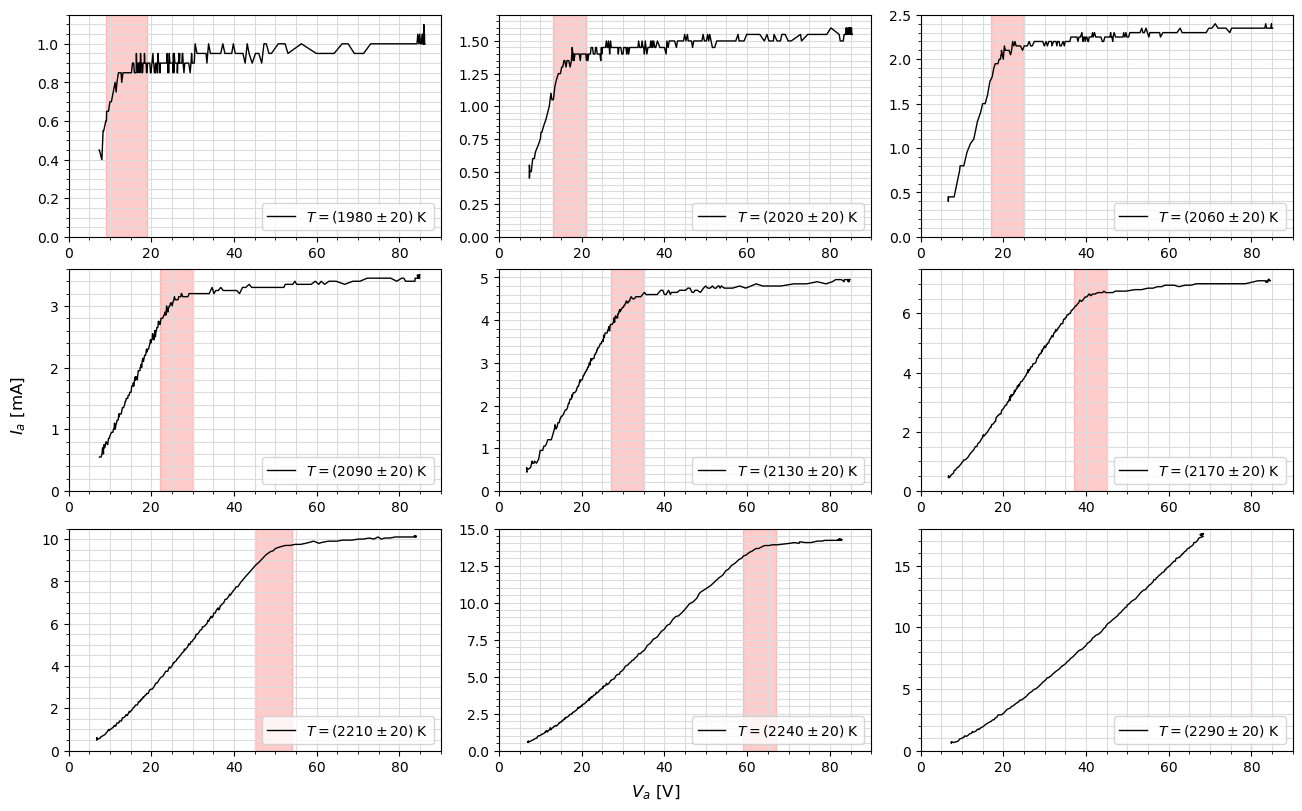

In [15]:
#@title Gráficas de las regiones de transición seleccionadas
fig, axs = plt.subplots(3, 3, figsize=(13, 8), layout='constrained')
#ax.scatter(T_r, np.power(I, 2) * R_W)
for i in range(len(V_a)):
  I = i // 3
  J = i % 3
  lbl = f'$T = ({int(T_r[i] - (T_r[i] % 10))} \pm 20)$ K'
  axs[I][J].plot(
    V_a[i],
    I_a[i]*1000,  # [mA]
    label=lbl,
    lw=1,
    c='k',
    zorder=2,
  )
  axs[I][J].minorticks_on()
  axs[I][J].grid(True, which='both', color='gainsboro')
  axs[I][J].set_xlim([0, 90])
  axs[I][J].set_ylim([0, y_lims[i]])
  axs[I][J].fill_between(V_transiscion[i], y1=15, color='r', alpha=.2)
  axs[I][J].legend(loc='lower right')

fig.supxlabel('$V_a$ [V]')
fig.supylabel('$I_a$ [mA]')

In [16]:
#@title Separación de datos para la región de Child y la región de Richardson
V_Child = [V_a[i][np.where(V_a[i] < V_transiscion[i][0])] for i in range(len(V_a))]
I_Child = [I_a[i][np.where(V_a[i] < V_transiscion[i][0])] for i in range(len(I_a))]

V_Richardson = [V_a[i][np.where(V_a[i] > V_transiscion[i][1])] for i in range(len(V_a))]
I_Richardson = [I_a[i][np.where(V_a[i] > V_transiscion[i][1])] for i in range(len(I_a))]

Text(0.02, 0.5, '$I_a$ [mA]')

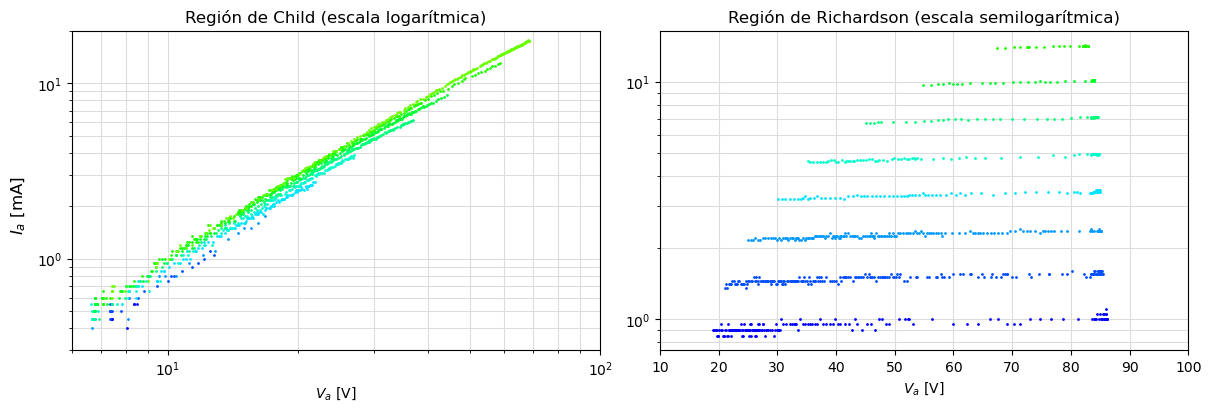

In [17]:
#@title Gráfica corriente-voltaje separadas en regiones
fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')
for i in range(len(V_a)):
  axs[0].scatter(
    V_Child[i],
    I_Child[i]*1000,  # [mA]
    label=f'$I_h = ({I_h[i]:.2f} \pm 0.01)$ A',
    marker='.',
    s=4,
    c=colores[i],
    zorder=2,
  )
  axs[1].scatter(
    V_Richardson[i],
    I_Richardson[i]*1000,  # [mA]
    label=f'$I_h = ({I_h[i]:.2f} \pm 0.01)$ A',
    marker='.',
    s=4,
    c=colores[i],
    zorder=2,
  )
  axs[0].grid(True, which='both', color='gainsboro')
  axs[1].grid(True, which='both', color='gainsboro')

axs[0].set_xlim([6, 100])
axs[0].set_ylim([0.3, 20])
axs[1].set_xlim([10, 100])

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].title.set_text('Región de Child (escala logarítmica)')
axs[1].title.set_text('Región de Richardson (escala semilogarítmica)')
axs[0].set_xlabel('$V_a$ [V]')
axs[1].set_xlabel('$V_a$ [V]')
fig.supylabel('$I_a$ [mA]')

# Comprobación experimental de la ley de Child y relación carga-masa
De forma similar a como se comprobó la ley de Stefan-Boltzmann, acá primero se realiza una relación potencial para comprobar la relación potencial entre la densidad de corriente $j$ y el voltaje de aceleración, y luego una vez se tienen los resultados esperados (potencia $\approx 1.5$) se realiza una regresión lineal para encontrar la relación carga-masa.

-  Ley de Child para cilíndros coaxiales:
$$
j = \frac{I}{\ell_\text{efectiva}} = \frac{8 \pi \epsilon_0}{9 b \beta^2} \sqrt{\frac{2 e}{m}} V_A^{3/2}.
$$

-  Ecuación de regresión potencial:
$$
I_A = e^b V_A^a,
$$
con $X = \ln V_A$ y $Y = \ln I$, tal que $e^b = \frac{8 \pi \epsilon_0}{9 b \beta^2} \sqrt{\frac{2 e}{m}} \ell_\text{efectiva}$ y $a = 1.5$.

In [18]:
#@title Regresión potencial por MMC para los valores de la región de Child
Child_regr = []
for i in range(1, len(V_Child)):
  Child_regr.append(OLS_regr(np.log(V_Child[i]), np.log(I_Child[i])))

Child_regr = np.transpose(np.array(Child_regr))

In [19]:
#@title Tabla coeficientes de la regresión de la región de Child
df = pd.DataFrame({
  'Potencia (a)': Child_regr[0],
  'Error estándar (Δa)': Child_regr[2],
  'Error relativo [%]': 100 * Child_regr[2] / Child_regr[0],
  '|a - 1.5|/1.5 [%]': 100 * np.abs(Child_regr[0] - 1.5) / 1.5,
  'Intercepto (b)': Child_regr[1],
  'Error estándar (Δb)': Child_regr[3],
  'R²': np.power(Child_regr[4], 2),
})

df.index += 2
display(df)

,Potencia (a),Error estándar (Δa),Error relativo [%],|a - 1.5|/1.5 [%],Intercepto (b),Error estándar (Δb),R²
2,1.405922,0.090297,6.422631,6.271834,-10.415363,0.199921,0.981281
3,1.496244,0.080151,5.356829,0.250393,-10.587588,0.182802,0.985462
4,1.480710,0.009530,0.643631,1.286024,-10.443676,0.025525,0.995546
5,1.535719,0.009816,0.639194,2.381241,-10.561710,0.027902,0.995242
6,1.505667,0.006868,0.456129,0.377830,-10.432087,0.020973,0.996414
7,1.494540,0.004646,0.310853,0.363984,-10.344904,0.014152,0.998071
8,1.494033,0.005222,0.349550,0.397833,-10.298771,0.016052,0.997283
9,1.483555,0.004127,0.278188,1.096340,-10.263722,0.014799,0.998478


In [20]:
#@title Potencia y relación carga masa promedio
a_sem = df['Potencia (a)'].sem() * t.ppf(.975, df['Potencia (a)'].count() - 1)
Delta_a_mean = np.sqrt(a_sem**2 + df['Error estándar (Δa)'].mean()**2)

b_mean = df['Intercepto (b)'].mean()
eb = np.exp(b_mean)

b_sem = df['Intercepto (b)'].sem() * t.ppf(.975, df['Intercepto (b)'].count() - 1)
Delta_b_total = np.sqrt(df['Error estándar (Δb)'].mean()**2 + b_sem**2)
B = (np.exp(b + Delta_b_total) + np.exp(b - Delta_b_total)) / 2
Delta_B = (np.exp(b + Delta_b_total) - np.exp(b - Delta_b_total)) / 2

rel_carga_masa =(((eb * 9 * RADIO_ANODO * BETA2) / (L_EFECTIVA * 8 * np.pi * EPSILON_0))**2) / 2
Delta_rel_carga_masa = 2 * rel_carga_masa * np.sqrt((Delta_B / B)**2 + (DELTA_RADIO_ANODO / RADIO_ANODO)**2 + (DELTA_L_EFECTIVA / L_EFECTIVA)**2 + (DELTA_EPSILON_0 / EPSILON_0)**2)
AUx = df['Potencia (a)'].mean()

print(f'Potencia promedio = ({AUx:.2f} ± {Delta_a_mean:.2f})')
print(f'Relación carga masa promedio = ({rel_carga_masa:.1e} ± {Delta_rel_carga_masa:.0e})')

Potencia promedio = (1.49 ± 0.04)
Relación carga masa promedio = (2.6e+12 ± 6e+11)


# Determinación de la constante de Richardson y función trabajo

Como se debe tener que la corriente $I_A \propto T^2 e^T$ (dado nuestro montaje experimental la dependencia con $T^2$ no se puede determinar con precisión), de tal forma que:

$$
I_A = A A_0 T^2 e^{-\phi / k T}.
$$

Con $A$ el área efectiva del filamento. Al dividir por $T^2$ y luego al tomar el logaritmo natural a ambos lados,

$$
\ln \left(\frac{I_\text{sat}}{T^2}\right) = \ln\left(A A_0\right) - \frac{\phi}{k T},
$$

se tiene la linealización:

$$
Y = b + m X
$$

con $Y = \ln \left(I_\text{sat} / T^2\right)$, $X = T^{-1}$, $m = - \phi / k$ y $b = \ln\left(A A_0\right)$.

De la pendiente $m$ se puede calcular la función trabajo del Tungsteno como:

$$
\boxed{\phi = - m k,}
$$

donde $k$ es la constante de Boltzmann.

Del intercepto $b$, exponenciando a ambos lados

$$
e^b = A A_0 \implies \boxed{A_0 = \frac{e^b}{A}}
$$

In [21]:
#@title Corriente de saturación y transformación de los datos para la regresión
I_sat = []
for I in I_Richardson[:-1]:
  I = I[~np.isnan(I)]
  I_sat.append(I[-1])
I_sat = np.array(I_sat)
Delta_I_sat = 0.01 * I_sat + 0.005 * 30 / 1000

X = 1 / T_r[:-1]
Y = np.log(I_sat / np.power(T_r[:-1], 2))
Delta_X = Delta_T_r[:-1] / np.power(T_r[:-1], 2)
Delta_Y = np.sqrt(np.power(Delta_I_sat / I_sat, 2) + np.power(2 * Delta_T_r[:-1] / T_r[:-1], 2))

x_lims = np.array([0.000438, 0.000512])
y_lims = np.array([-22.4, -19.5])

In [22]:
#@title Regresión exponencial por MMC para los valores de la región de Richardson
m, b, delta_m, delta_b, r = OLS_regr(1 / T_r[:-1], np.log(I_sat / np.power(T_r[:-1], 2)))

In [25]:
#@title Tabla coeficientes de la regresión de la región de Richardson
phi = - m * K_BOLTZMANN * 6.242e+18  # [eV]
Delta_phi = - delta_m * K_BOLTZMANN * 6.242e+18  # [eV]

A_0 = np.exp(b) / AREA_FILAMENTO
Delta_A_0 = A_0 * np.sqrt(delta_b**2 + (DELTA_AREA_FILAMENTO / AREA_FILAMENTO)**2)

print(f'Constante de Richardson = ({A_0:.1e} ± {Delta_A_0:.0e}) A m⁻² K⁻²')
print(f'Función trabajo del filamento = ({phi:.1f} ± {-Delta_phi:.1f}) eV')
print(f'R² = {r*r:.4f}')

regr_label = f'$Y = ({(m / 10000):.1f} \pm {(delta_m / 10000):.1f}) \\times 10^4 \; X - ({-b:.1f} \pm {delta_b:.1f})$'

Constante de Richardson = (8.2e+04 ± 6e+04) A m⁻² K⁻²
Función trabajo del filamento = (3.5 ± 0.1) eV
R² = 0.9986


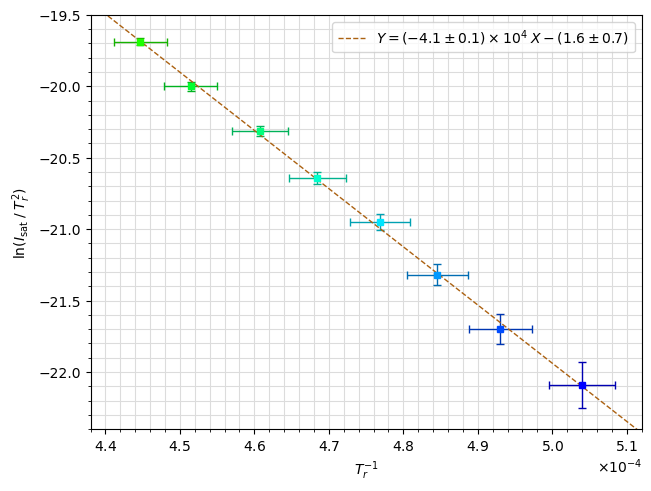

In [24]:
fig, ax = plt.subplots(layout='constrained')
for i in range(len(I_sat)):
  ax.errorbar(
    X[i],
    Y[i],
    xerr=Delta_X[i],
    yerr=Delta_Y[i],
    capsize=3,
    c=colores[i],
    ecolor=colores_err[i],
    elinewidth=1,
    fmt='s',
    ms=4.5,
    zorder=2,
  )
ax.plot(
  x_lims,
  x_lims * m + b,
  ls='--',
  c='#ab6111',
  lw=1,
  label=regr_label,
  zorder=2,
)
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlim(x_lims)
ax.set_ylim(y_lims)
ax.set_xlabel('$T_r^{-1}$')
ax.set_ylabel('$\ln (I_\\text{sat} \;/\; T_r^2)$')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.legend()